#### task 1

#### task 2

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

class ResBlock(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim)
        )
        
    def forward(self, x):
        return x + self.net(x)

class ResNetAutoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, num_blocks):
        super().__init__()
        
        # Encoder
        self.encoder_input = nn.Linear(input_size, hidden_size)
        self.encoder_blocks = nn.ModuleList([
            ResBlock(hidden_size, hidden_size * 2)
            for _ in range(num_blocks)
        ])
        self.encoder_output = nn.Linear(hidden_size, bottleneck_size)
        
        # Decoder
        self.decoder_input = nn.Linear(bottleneck_size, hidden_size)
        self.decoder_blocks = nn.ModuleList([
            ResBlock(hidden_size, hidden_size * 2)
            for _ in range(num_blocks)
        ])
        self.decoder_output = nn.Linear(hidden_size, input_size)
        
    def encode(self, x):
        h = self.encoder_input(x)
        for block in self.encoder_blocks:
            h = block(h)
        return self.encoder_output(h)
    
    def decode(self, z):
        h = self.decoder_input(z)
        for block in self.decoder_blocks:
            h = block(h)
        return self.decoder_output(h)
    
    def forward(self, x):
        return self.decode(self.encode(x))

def compute_kernel(x, y, bandwidths):
    """
    Compute sum of RBF kernels with different bandwidths
    """
    xx = x.unsqueeze(1)  # (N, 1, D)
    yy = y.unsqueeze(0)  # (1, M, D)
    distances = (xx - yy).pow(2).sum(2)  # (N, M)
    
    kernels = torch.zeros_like(distances)
    for bandwidth in bandwidths:
        kernels += torch.exp(-distances / (2 * bandwidth ** 2))
    
    return kernels

def compute_mmd(x, y, bandwidths):
    """
    Compute Maximum Mean Discrepancy between x and y distributions
    """
    x_kernel = compute_kernel(x, x, bandwidths)
    y_kernel = compute_kernel(y, y, bandwidths)
    xy_kernel = compute_kernel(x, y, bandwidths)
    
    N = x_kernel.size(0)
    M = y_kernel.size(0)
    
    xx = x_kernel.sum() / (N * (N - 1))  # exclude diagonal
    yy = y_kernel.sum() / (M * (M - 1))  # exclude diagonal
    xy = xy_kernel.mean()
    
    mmd = xx + yy - 2 * xy
    return mmd

def train_mmd_autoencoder(model, train_loader, test_loader, epochs, 
                         lr=0.001, bandwidths=[0.1, 0.2, 0.4, 0.8, 1.6], 
                         mmd_weight=0.1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    reconstruction_criterion = nn.MSELoss()
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_data in train_loader:
            batch_data = batch_data[0].to(device)
            batch_size = batch_data.size(0)
            
            optimizer.zero_grad()
            
            # Forward pass
            codes = model.encode(batch_data)
            reconstructed = model.decode(codes)
            
            # Compute reconstruction loss
            recon_loss = reconstruction_criterion(reconstructed, batch_data)
            
            # Compute MMD loss
            reference = torch.randn_like(codes)  # Sample from standard normal
            mmd_loss = compute_mmd(codes, reference, bandwidths)
            
            # Total loss
            loss = recon_loss + mmd_weight * mmd_loss
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Testing
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch_data in test_loader:
                batch_data = batch_data[0].to(device)
                reconstructed = model(batch_data)
                codes = model.encode(batch_data)
                reference = torch.randn_like(codes)
                
                recon_loss = reconstruction_criterion(reconstructed, batch_data)
                mmd_loss = compute_mmd(codes, reference, bandwidths)
                loss = recon_loss + mmd_weight * mmd_loss
                
                test_loss += loss.item()
                
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    return train_losses, test_losses

def generate_samples(model, n_samples):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        # Sample from standard normal
        z = torch.randn(n_samples, 2).to(device)
        # Generate samples through decoder
        samples = model.decode(z).cpu().numpy()
    return samples

# Example usage:
def run_mmd_experiment(n_samples=1000, noise=0.1, hidden_size=64, num_blocks=3,
                      epochs=100, batch_size=32, mmd_weight=0.1):
    # Prepare data
    X, _ = make_moons(n_samples=n_samples, noise=noise)
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
    
    train_dataset = TensorDataset(torch.FloatTensor(X_train))
    test_dataset = TensorDataset(torch.FloatTensor(X_test))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Create model
    model = ResNetAutoencoder(
        input_size=2,
        bottleneck_size=2,  # No dimensional reduction
        hidden_size=hidden_size,
        num_blocks=num_blocks
    )
    
    # Train model
    train_losses, test_losses = train_mmd_autoencoder(
        model, 
        train_loader, 
        test_loader, 
        epochs=epochs,
        mmd_weight=mmd_weight
    )
    
    # Generate and visualize results
    synthetic_samples = generate_samples(model, n_samples=1000)
    
    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original data
    ax1.scatter(X_test[:, 0], X_test[:, 1], alpha=0.5)
    ax1.set_title('Original Data')
    
    # Reconstructions
    model.eval()
    with torch.no_grad():
        reconstructed = model(torch.FloatTensor(X_test).to(model.decoder_output.weight.device))
        reconstructed = reconstructed.cpu().numpy()
    ax2.scatter(reconstructed[:, 0], reconstructed[:, 1], alpha=0.5)
    ax2.set_title('Reconstructions')
    
    # Generated samples
    ax3.scatter(synthetic_samples[:, 0], synthetic_samples[:, 1], alpha=0.5)
    ax3.set_title('Generated Samples')
    
    plt.tight_layout()
    plt.show()
    
    return model, train_losses, test_losses

Epoch [10/100], Train Loss: 0.0378, Test Loss: 0.0593
Epoch [20/100], Train Loss: 0.0377, Test Loss: 0.0522
Epoch [30/100], Train Loss: 0.0362, Test Loss: 0.0561
Epoch [40/100], Train Loss: 0.0384, Test Loss: 0.0552
Epoch [50/100], Train Loss: 0.0370, Test Loss: 0.0445
Epoch [60/100], Train Loss: 0.0353, Test Loss: 0.0507
Epoch [70/100], Train Loss: 0.0334, Test Loss: 0.0489
Epoch [80/100], Train Loss: 0.0334, Test Loss: 0.0460
Epoch [90/100], Train Loss: 0.0366, Test Loss: 0.0480
Epoch [100/100], Train Loss: 0.0338, Test Loss: 0.0511


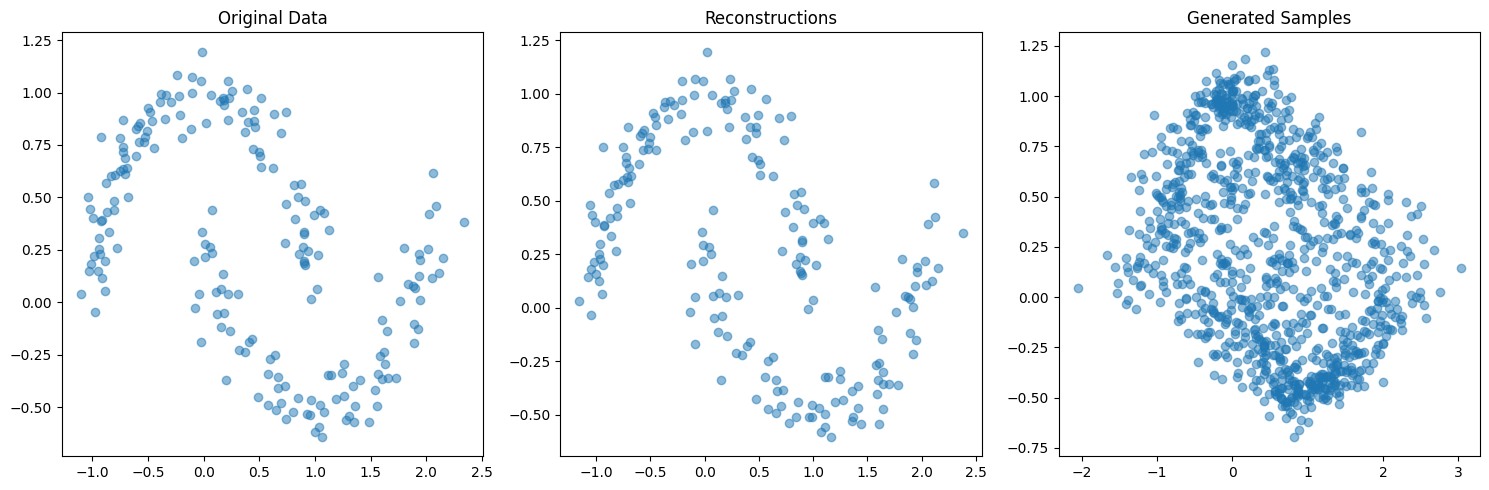

In [22]:
model, train_losses, test_losses = run_mmd_experiment(
    n_samples=1000,
    noise=0.1,
    hidden_size=64,
    num_blocks=3,
    epochs=100,
    mmd_weight=0.1
)

<!-- We continue with the two mo ons dataset, but this time b ottleneck size 2. Since training now lacks
the regularizing eect of the lossy compression (which enforces the co des to fo cus on the imp ortant
data features), we need an additional loss term. We use the maximum mean discrepancy (MMD)
b etween the co de distribution (i.e. the push-forward through the enco der) and a 2-dimensional
standard normal. This loss pulls the co de distribution towards the standard normal, so that we can
later generate synthetic data by sampling from the standard normal and transform the samples
through the deco der. The kernel for MMD shall b e a sum of squared exp onentials or inverse multi-
quadratics at multiple bandwidths (the numb er and values of the bandwidths are hyp erparameters
 use three to seven bandwidths such that each value is twice the next smaller one). The training
loss is a weighted sum of the squared reconstruction error and the MMD, with the weight b eing yet
another hyp erparameter.
Use the auto enco der from task 1 (with bottleneck_size=2) or implement a residual network (ResNet
 it gave b etter results in our exp eriments). Recall that a ResNet consists of L residual blo cks
computing zl= zl−1 + fl(zl−1) for l = 1, ..., L, where z0 are the original data. The fl() are fully
connected networks with one or two hidden layers whose width is typically larger than the input
dimension. Implement a new function train_mmd_autoencoder() and train the mo del at noise level 0.1.
Visualize the reconstructed vs. original data, and the co de distribution. Check that the reconstruc-
tion error is much less than what you got with a b ottleneck of size 1. Generate synthetic data by
passing standard normal samples through the deco der and visualize their quality. Comment on your
ndings -->

Comparison of the results of the autoencoder with bottleneck size 1 and 2.

- The autoencoder with bottleneck size 2 has a lower reconstruction error than the autoencoder with bottleneck size 1. 

- The autoencoder with bottleneck size 2 has a higher capacity to learn the data distribution and can reconstruct the data more accurately. 

- The autoencoder with bottleneck size 2 also has a more complex architecture, which allows it to capture more features of the data.

#### task 3

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

class DigitsAutoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super().__init__()
        
        # Build encoder
        encoder_layers = []
        # First layer
        encoder_layers.extend([
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        ])
        
        # Middle layers
        for _ in range(layers - 1):
            encoder_layers.extend([
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU()
            ])
            
        # Bottleneck layer
        encoder_layers.append(nn.Linear(hidden_size, bottleneck_size))
        
        # Build decoder
        decoder_layers = []
        # First layer from bottleneck
        decoder_layers.extend([
            nn.Linear(bottleneck_size, hidden_size),
            nn.ReLU()
        ])
        
        # Middle layers
        for _ in range(layers - 1):
            decoder_layers.extend([
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU()
            ])
            
        # Output layer
        decoder_layers.append(nn.Linear(hidden_size, input_size))
        
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)
        
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

def prepare_digits_data(batch_size=32):
    # Load digits dataset
    digits = load_digits()
    X = digits.data.astype('float32')
    y = digits.target
    
    # Normalize the data
    X = X / 16.0  # Scale to [0,1]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create dataloaders
    train_dataset = TensorDataset(torch.FloatTensor(X_train))
    test_dataset = TensorDataset(torch.FloatTensor(X_test))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, test_loader, X_train, X_test, y_train, y_test

def train_digits_autoencoder(model, train_loader, test_loader, epochs, learning_rate=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_data in train_loader:
            batch_data = batch_data[0].to(device)
            optimizer.zero_grad()
            reconstructed = model(batch_data)
            loss = criterion(reconstructed, batch_data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Testing
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch_data in test_loader:
                batch_data = batch_data[0].to(device)
                reconstructed = model(batch_data)
                loss = criterion(reconstructed, batch_data)
                test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
            
    return train_losses, test_losses

def visualize_reconstructions(model, X_test, n_samples=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test[:n_samples]).to(device)
        reconstructed = model(X_test_tensor).cpu().numpy()
    
    fig, axes = plt.subplots(2, n_samples, figsize=(n_samples * 1.5, 3))
    for i in range(n_samples):
        # Original
        axes[0, i].imshow(X_test[i].reshape(8, 8), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original')
            
        # Reconstructed
        axes[1, i].imshow(reconstructed[i].reshape(8, 8), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed')
    
    plt.tight_layout()
    plt.show()

def analyze_autoencoder(bottleneck_size, hidden_size=128, layers=2, epochs=100):
    # Prepare data
    train_loader, test_loader, X_train, X_test, y_train, y_test = prepare_digits_data()
    
    # Create and train model
    model = DigitsAutoencoder(64, bottleneck_size, hidden_size, layers)
    train_losses, test_losses = train_digits_autoencoder(model, train_loader, test_loader, epochs)
    
    # Visualize reconstructions
    visualize_reconstructions(model, X_test)
    
    # Get reconstructions for all test data
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        reconstructed_test = model(torch.FloatTensor(X_test).to(device)).cpu().numpy()
    
    # Train Random Forest classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Get predictions for original and reconstructed data
    orig_pred = rf.predict(X_test)
    recon_pred = rf.predict(reconstructed_test)
    
    # Calculate prediction agreement
    agreement = np.mean(orig_pred == recon_pred)
    print(f"\nPrediction agreement between original and reconstructed: {agreement:.2%}")
    
    # For bottleneck_size=2, visualize latent space
    if bottleneck_size == 2:
        plt.figure(figsize=(10, 8))
        with torch.no_grad():
            latent = model.encode(torch.FloatTensor(X_test).to(device)).cpu().numpy()
        plt.scatter(latent[:, 0], latent[:, 1], c=y_test, cmap='tab10')
        plt.colorbar(label='Digit')
        plt.title('2D Latent Space')
        plt.xlabel('First Dimension')
        plt.ylabel('Second Dimension')
        plt.show()
    
    # Generate synthetic data using GMM
    with torch.no_grad():
        latent = model.encode(torch.FloatTensor(X_test).to(device)).cpu().numpy()
    
    gmm = GaussianMixture(n_components=10, random_state=42)
    gmm.fit(latent)
    
    # Generate synthetic samples
    synthetic_latent = gmm.sample(n_samples=20)[0]
    with torch.no_grad():
        synthetic_digits = model.decode(torch.FloatTensor(synthetic_latent).to(device)).cpu().numpy()
    
    # Visualize synthetic digits
    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(20):
        ax = axes[i // 10, i % 10]
        ax.imshow(synthetic_digits[i].reshape(8, 8), cmap='gray')
        ax.axis('off')
    plt.suptitle('Synthetic Digits')
    plt.tight_layout()
    plt.show()
    
    # Classify synthetic data
    synthetic_pred = rf.predict(synthetic_digits)
    print("\nPredicted classes for synthetic digits:", synthetic_pred)
    
    return model, train_losses, test_losses

# Function to run experiments with different bottleneck sizes
def run_bottleneck_experiments():
    bottleneck_sizes = [2, 4, 8]
    for size in bottleneck_sizes:
        print(f"\nRunning experiment with bottleneck size {size}")
        analyze_autoencoder(size)


Running experiment with bottleneck size 2
Epoch [10/100], Train Loss: 0.0385, Test Loss: 0.0392
Epoch [20/100], Train Loss: 0.0335, Test Loss: 0.0348
Epoch [30/100], Train Loss: 0.0305, Test Loss: 0.0328
Epoch [40/100], Train Loss: 0.0288, Test Loss: 0.0319
Epoch [50/100], Train Loss: 0.0273, Test Loss: 0.0311
Epoch [60/100], Train Loss: 0.0263, Test Loss: 0.0308
Epoch [70/100], Train Loss: 0.0253, Test Loss: 0.0296
Epoch [80/100], Train Loss: 0.0246, Test Loss: 0.0300
Epoch [90/100], Train Loss: 0.0241, Test Loss: 0.0298
Epoch [100/100], Train Loss: 0.0235, Test Loss: 0.0296


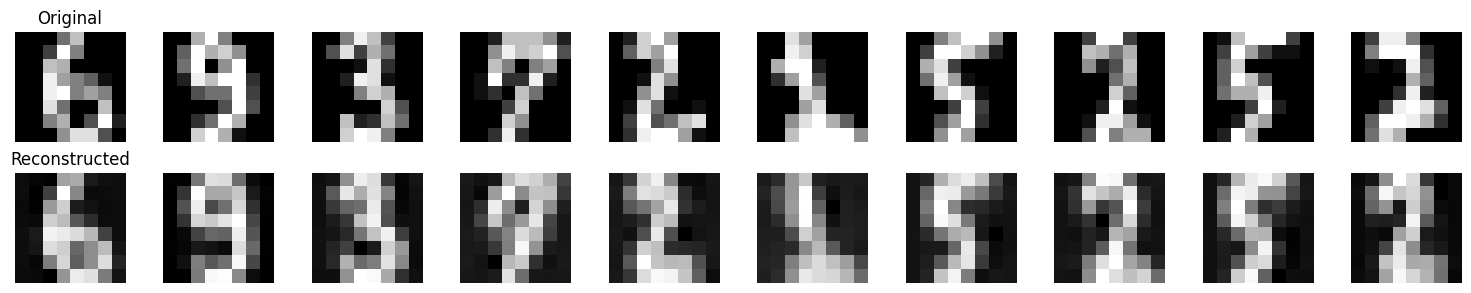


Prediction agreement between original and reconstructed: 91.11%


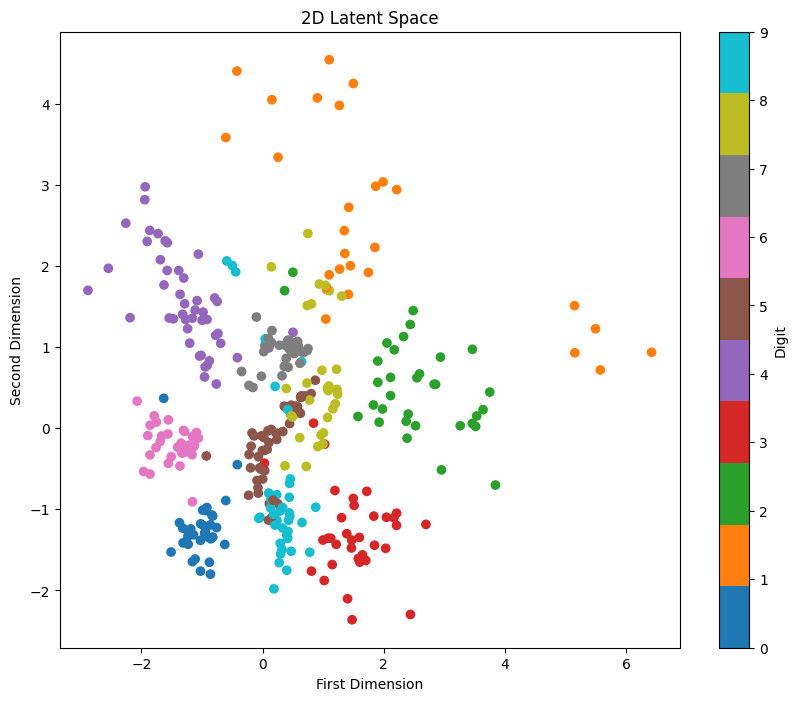

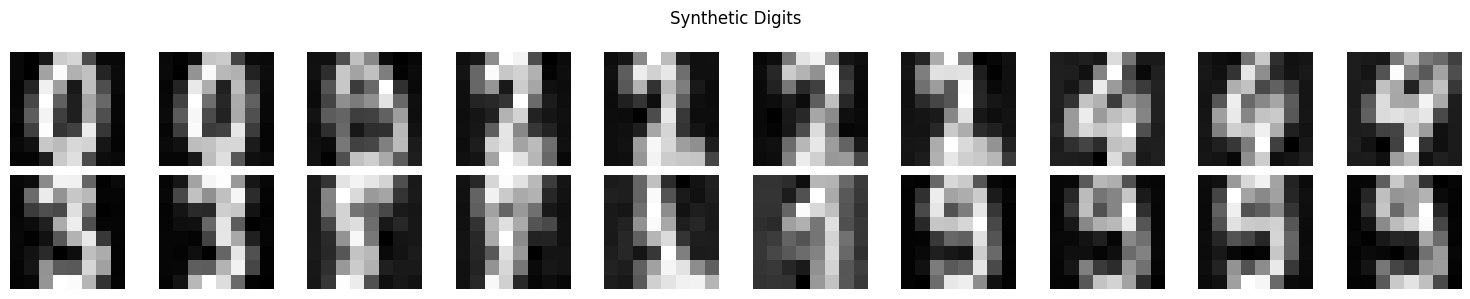


Predicted classes for synthetic digits: [0 0 9 2 2 2 2 4 4 4 3 3 5 7 1 1 9 9 9 9]

Running experiment with bottleneck size 4
Epoch [10/100], Train Loss: 0.0284, Test Loss: 0.0294
Epoch [20/100], Train Loss: 0.0233, Test Loss: 0.0245
Epoch [30/100], Train Loss: 0.0205, Test Loss: 0.0223
Epoch [40/100], Train Loss: 0.0191, Test Loss: 0.0215
Epoch [50/100], Train Loss: 0.0179, Test Loss: 0.0208
Epoch [60/100], Train Loss: 0.0171, Test Loss: 0.0203
Epoch [70/100], Train Loss: 0.0164, Test Loss: 0.0196
Epoch [80/100], Train Loss: 0.0158, Test Loss: 0.0200
Epoch [90/100], Train Loss: 0.0153, Test Loss: 0.0192
Epoch [100/100], Train Loss: 0.0149, Test Loss: 0.0193


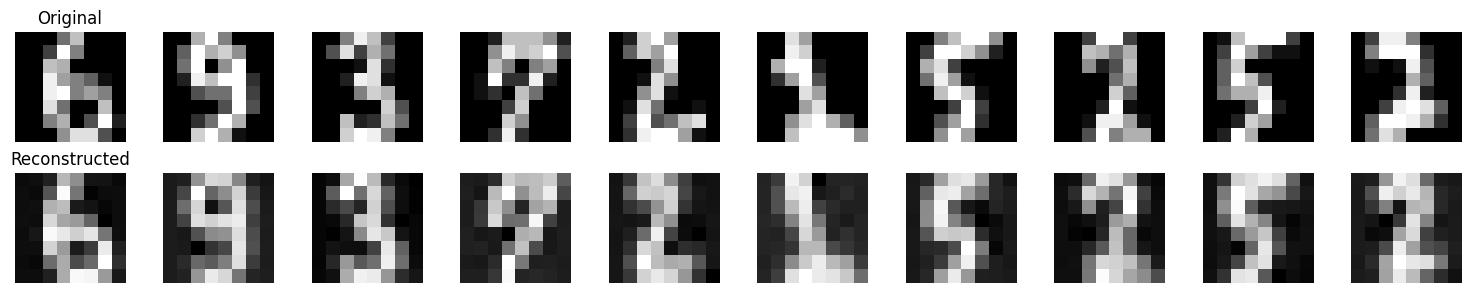


Prediction agreement between original and reconstructed: 91.67%


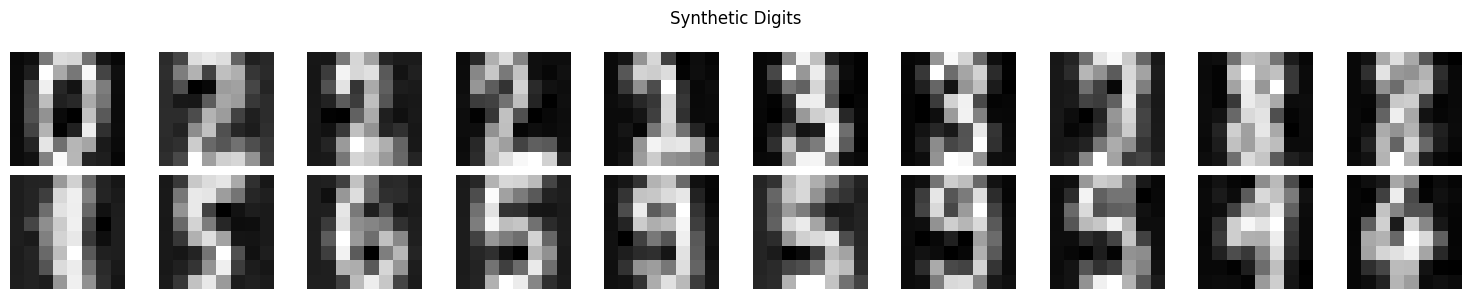


Predicted classes for synthetic digits: [0 2 2 2 2 3 3 3 8 8 1 5 6 5 9 5 9 9 1 4]

Running experiment with bottleneck size 8
Epoch [10/100], Train Loss: 0.0219, Test Loss: 0.0217
Epoch [20/100], Train Loss: 0.0152, Test Loss: 0.0160
Epoch [30/100], Train Loss: 0.0133, Test Loss: 0.0145
Epoch [40/100], Train Loss: 0.0122, Test Loss: 0.0135
Epoch [50/100], Train Loss: 0.0114, Test Loss: 0.0132
Epoch [60/100], Train Loss: 0.0109, Test Loss: 0.0128
Epoch [70/100], Train Loss: 0.0104, Test Loss: 0.0126
Epoch [80/100], Train Loss: 0.0100, Test Loss: 0.0123
Epoch [90/100], Train Loss: 0.0096, Test Loss: 0.0120
Epoch [100/100], Train Loss: 0.0095, Test Loss: 0.0120


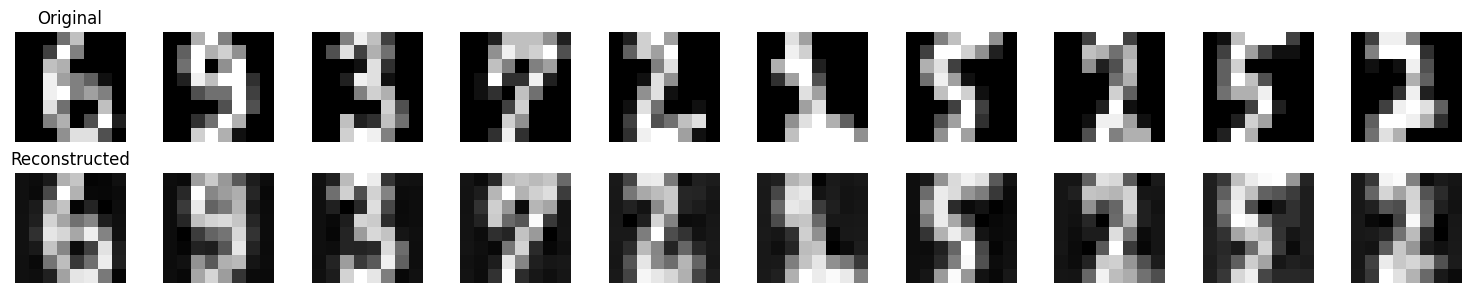


Prediction agreement between original and reconstructed: 95.28%


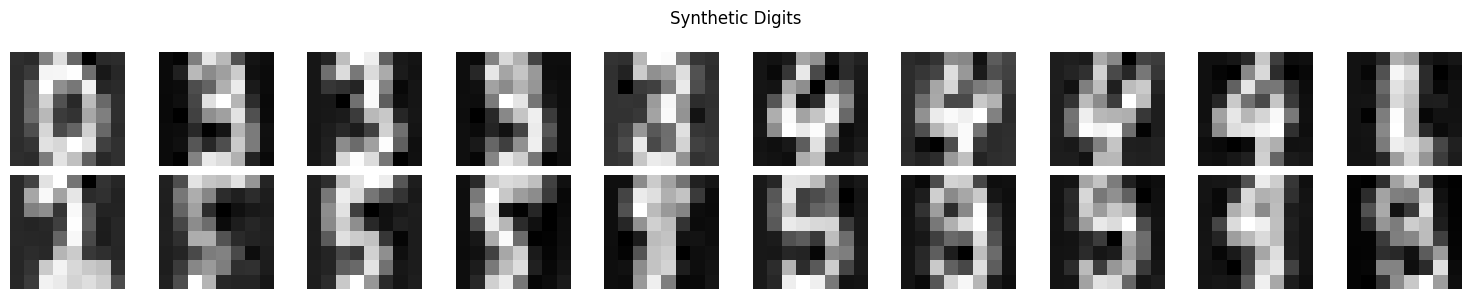


Predicted classes for synthetic digits: [0 9 3 3 3 4 4 4 4 1 2 5 5 5 8 9 9 9 1 9]


In [17]:
# Run experiments for all bottleneck sizes
run_bottleneck_experiments()

Comparison of the results of the autoencoder with bottleneck size 2, 4, and 8 on the digits dataset.

- The autoencoder with bottleneck size 8 has the least reconstruction error, followed by the autoencoder with bottleneck size 4 and 2.

- The autoencoder with bottleneck size 8 has the highest capacity to learn the data distribution and can reconstruct the data most accurately.

- The autoencoder with bottleneck size 2 has the lowest capacity to learn the data distribution and can reconstruct the data least accurately.

Although the autoencoder with bottleneck size 2 has the lowest capacity, it can still recognize the digit labels in the reconstructed data.

Generated synthetic digits are clear and recognizable, and the classifier performs well on the synthetic data.